In [2]:
import numpy as np
from random import random
import helpers as hlp
from tqdm import tqdm

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [3]:
# import data from DNN training
extracted_coefficients_directory = '../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

theta_prior = 2.5

In [4]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 10000 + 1
L = 2

# number of parameters of theta
q = B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.append(np.zeros(10), np.random.rand(1,))

# stepsize
epsilon = 0.001

r_m = np.zeros(theta_m_1.shape[0])

tau_start = theta_m_1[p]

In [5]:
W = np.array([B_zeta[i,:].dot(B_zeta[i,:]) for i in range(0, n)])
S = np.sqrt(1/(1 + W*tau_start))
S2 = S**2

 need to write functions for
- log-density of $\log \lambda_j^2$
- gradient of log-density of $\log \lambda_j^2$

- log-density of $\log \tau$
- gradient of $\log \tau$

- log-density of $\beta$
- gradient of $\beta$

In [6]:
def delta_beta(z, u, B, S, beta, tBB):
    return((z*(1/S)).dot(B) - beta.T.dot(tBB) - beta/np.exp(u))

def delta_tau(u, B, S2, dS2, z, beta, theta_prior, betaBt):
    p = B.shape[1]
    return(- 0.5*np.sum(dS2/S2) 
           - 0.5*np.sum((z**2)*(-dS2/(S2**2)))
           + np.sum(betaBt*((-0.5*dS2/(S2**1.5))*z)) 
           - (0.5*p - 0.5) 
           + 0.5*(beta.T.dot(beta))/np.exp(u) 
           - 0.5*(np.exp(u)/theta_prior)**0.5 )

def compdS(tau2, W):
    tildeW = tau2*W
    S2 = 1/(1+tildeW)
    dS2 = -tildeW/((1+tildeW)**2)
    ddS2 = -tildeW/((1+tildeW)**2) + 2*(tildeW**2)/((1+tildeW)**3)
    
    S = np.sqrt(S2)
    return(S2, dS2, ddS2, S)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, theta, W, theta_prior):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    u = vartheta_new[p]

    S2, dS2, ddS2, S = compdS(np.exp(u), W)
    
    # Gradient w.r.t. beta
    grad_beta = delta_beta(z, u, B, S, beta_t, tBB)
    # Gradient w.r.t. tau
    grad_tau = delta_tau(u, B, S2, dS2, z, beta_t, theta_prior, betaBt)
    
    return(np.append(grad_beta, grad_tau))

def log_density(z, u,  beta, B, p,  n, S, S2, tBB, theta, betaBt):   
    term1 = - 0.5*np.sum(np.log(S2))
    term2 =  - 0.5*z.dot((1/S2)*z)
    term3 = + betaBt.dot(z*(1/S)) 
    term4 = - 0.5*beta.T.dot(tBB).dot(beta)
    term5 =  - 0.5/np.exp(u)*np.sum(beta**2)
    term6 =  - 0.5*u*(p-1)  - np.sqrt(np.exp(u)/theta)
    return (term1 + term2 + term3 +term4 + term5 + term6  )



In [7]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt, beta, W, theta_prior):
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, theta, W, theta_prior)

    # update momentum
    r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r_tilde).reshape(p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, theta, W, theta_prior)
    
    # update momentum again
    r_tilde = r_tilde + (epsilon/2)*Delta_theta_tilde
    
    return(theta_tilde, r_tilde)

In [8]:
r0 = np.repeat(None, M)
theta_tilde = np.repeat(None, M)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(10), np.random.rand(1,))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.zeros(11)
r_tilde[0] = np.zeros(11)
theta_m_1[1] = np.zeros(11)
all_thetas = []
theta_m_1[0] = np.zeros(11)
for m in tqdm(range(1, M - 1)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = theta_m_1[m].reshape(11,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], r_tilde[m], epsilon, n, z, p, B_zeta, tBB, betaBt, beta, W, theta_prior)
    
    S2, dS2, ddS2, S = compdS(np.exp(theta_tilde[m][p]), W)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    log_dens[m] = log_density(z, theta_tilde[m][p],  theta_tilde[m][0:p], B_zeta, p,  n, S, S2, tBB, theta_prior, betaBt)
    alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
    
    decision = np.random.uniform(0,1,1)
    if decision <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-8-2942d4dab446>:37: RuntimeWarning: invalid value encountered in true_divide
  alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
100%|█████████▉| 9999/10000 [43:41<00:00,  3.81it/s] 


IndexError: index 10001 is out of bounds for axis 0 with size 10001

In [9]:
np.mean(acc)

1.0

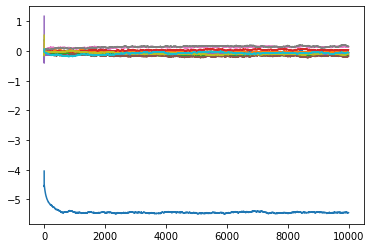

In [10]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)

In [13]:
theta_hmc = np.mean(all_thetas, axis = 0)
np.save('../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', all_thetas)

In [ ]:
# comparison with VA

In [18]:
vartheta_va = np.load('../../../data/commaai/va/filtered_gaussian_resampled/Ridge/vartheta.npy')#np.genfromtxt('../../../data/commaai/va/filtered_gaussian_resampled/Ridge/vartheta.csv', delimiter=",")

In [19]:
theta_va = np.mean(vartheta_va[int(0.9*50000):50000, :], axis = 0)

In [20]:
0.9*50000

45000.0

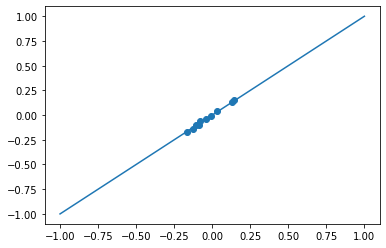

In [22]:
plt.scatter(theta_hmc[0:10], theta_va[0:10])
ident = [-1, 1.0]
plt.plot(ident,ident)

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
beta_va.shape